In [1]:
import numpy as np
from sklearn.cluster import KMeans
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import joblib

In [3]:
# Assuming embeddings are stored as a NumPy array or can be converted
embeddings_array = np.load("embeddings.npy")  # Shape: (n_samples, n_features)
print(f"Shape of embeddings: {embeddings_array.shape}")

Shape of embeddings: (152470, 1, 32)


In [4]:
# Remove the singleton dimension to make the array 2D
embeddings_array = embeddings_array.squeeze(axis=1)  # Shape will become (152470, 32)

# Verify the shape
print(f"Corrected shape of embeddings: {embeddings_array.shape}")

Corrected shape of embeddings: (152470, 32)


In [5]:
np.save("embeddings_corrected.npy", embeddings_array)

In [6]:
# Ensure the array is 2D
assert embeddings_array.ndim == 2, "Embeddings must be a 2D array (n_samples, n_features)."

In [9]:
# add player names to the metadata file

# Load the CSV files
embeddings_metadata = pd.read_csv("embeddings_metadata.csv")
minutes_played = pd.read_csv("C:/Users/Francesco/Dissertation/minutes-played_filtered.csv")

# Ensure the 'playerId' column exists in both files
assert 'playerId' in embeddings_metadata.columns, "'playerId' column is missing in embeddings_metadata.csv."
assert 'playerId' in minutes_played.columns and 'playerName' in minutes_played.columns, \
    "'playerId' or 'playerName' column is missing in minutes-played_filtered.csv."

# Create a mapping from playerId to playerName
player_id_to_name = minutes_played.set_index('playerId')['playerName'].to_dict()

# Map player names to embeddings metadata
embeddings_metadata['playerName'] = embeddings_metadata['playerId'].map(player_id_to_name)

# Save the updated embeddings metadata
embeddings_metadata.to_csv("embeddings_metadata_with_names.csv", index=False)

print("Updated embeddings_metadata.csv with player names saved as 'embeddings_metadata_with_names.csv'.")

C:\Users\Francesco\AppData\Local\Temp\ipykernel_11036\2957003902.py:5: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  minutes_played = pd.read_csv("C:/Users/Francesco/Dissertation/minutes-played_filtered.csv")


Updated embeddings_metadata.csv with player names saved as 'embeddings_metadata_with_names.csv'.


In [18]:
# Assuming 11 clusters 
n_clusters = 11 

# Train the K-Means model
kmeans = KMeans(n_clusters=n_clusters, random_state=42)
kmeans.fit(embeddings_array)

# Get the cluster assignments and cluster centers
cluster_labels = kmeans.labels_  # Shape: (n_samples,)
cluster_centers = kmeans.cluster_centers_  # Shape: (n_clusters, n_features)

c:\Users\Francesco\anaconda3\envs\NBA_Project\lib\site-packages\sklearn\cluster\_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


In [19]:
# visualize cluster assignments and centers
# Load metadata (if available)
metadata = pd.read_csv("embeddings_metadata_with_names.csv")

# Add cluster labels to metadata
metadata["cluster"] = cluster_labels

# Save metadata with clusters
metadata.to_csv("embeddings_with_clusters.csv", index=False)

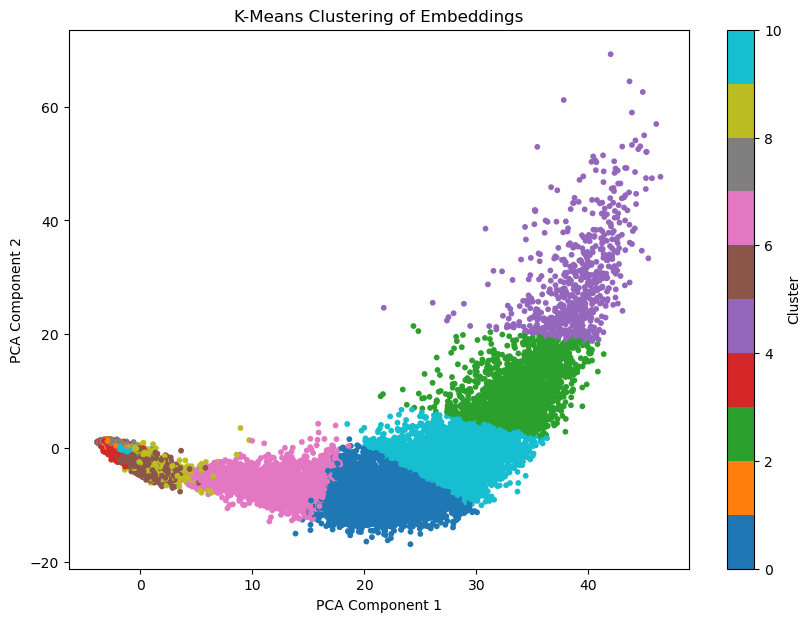

In [20]:
# PCA
# Reduce dimensions for visualization
pca = PCA(n_components=2)
reduced_embeddings = pca.fit_transform(embeddings_array)

# Plot the clusters
plt.figure(figsize=(10, 7))
scatter = plt.scatter(
    reduced_embeddings[:, 0], reduced_embeddings[:, 1], c=cluster_labels, cmap="tab10", s=10
)
plt.colorbar(scatter, label="Cluster")
plt.title("K-Means Clustering of Embeddings")
plt.xlabel("PCA Component 1")
plt.ylabel("PCA Component 2")
plt.show()

In [30]:
# Silhouette score to evaluate cluster quality
# with 8 clusters - score: 0.30
# with 6 clusters - score: 0.29
# with 11 clusters - score: 0.29
silhouette_avg = silhouette_score(embeddings_array, cluster_labels)
print(f"Silhouette Score: {silhouette_avg:.2f}")

Silhouette Score: 0.29


In [25]:
from sklearn.metrics.pairwise import cosine_similarity

def find_similar_players(player_id, embeddings, metadata, kmeans_model, top_n=5):
    """
    Find the top-N similar players to a given playerId based on k-means clusters and cosine similarity.
    
    Args:
    - player_id (int): The playerId to find similar players for.
    - embeddings (numpy.ndarray): The embeddings array of shape (n_samples, n_features).
    - metadata (pandas.DataFrame): Metadata containing playerId and other information.
    - kmeans_model (KMeans): Trained k-means model.
    - top_n (int): Number of similar players to return (default is 5).
    
    Returns:
    - pandas.DataFrame: Top-N similar players with playerId and similarity score.
    """
    # Ensure metadata and embeddings are aligned
    assert len(embeddings) == len(metadata), "Mismatch between embeddings and metadata rows."
    
    # Get indices of embeddings corresponding to the given playerId
    player_indices = metadata.index[metadata['playerId'] == player_id].tolist()
    if not player_indices:
        raise ValueError(f"PlayerId {player_id} not found in metadata.")
    
    # Get the embeddings for the given playerId
    player_embeddings = embeddings[player_indices]
    
    # Predict clusters for all embeddings
    cluster_labels = kmeans_model.predict(embeddings)
    
    # Find the cluster(s) to which the player's embeddings belong
    player_clusters = cluster_labels[player_indices]
    
    # Filter embeddings and metadata belonging to the same cluster(s)
    cluster_mask = np.isin(cluster_labels, player_clusters)
    cluster_embeddings = embeddings[cluster_mask]
    cluster_metadata = metadata[cluster_mask].reset_index(drop=True)
    
    # Compute similarity of player's embeddings to all cluster embeddings
    similarity_scores = cosine_similarity(player_embeddings, cluster_embeddings)
    
    # Flatten similarity scores and get corresponding metadata indices
    similarity_scores_flat = similarity_scores.max(axis=0)  # Take the maximum similarity for each embedding
    cluster_metadata['similarity'] = similarity_scores_flat
    
    # Filter to exclude the same playerId
    filtered_metadata = cluster_metadata[cluster_metadata['playerId'] != player_id]
    
    # Sort by similarity and return the top-N unique playerIds
    top_similar = (
        filtered_metadata
        .sort_values(by='similarity', ascending=False)
        .drop_duplicates(subset=['playerId'])
        .head(top_n)
    )
    
    return top_similar[['playerId', 'playerName', 'teamId', 'season', 'similarity']]

In [33]:
# Find similar players
player_id_to_search = 9991 # Giorgio Chiellini
top_similar_players = find_similar_players(player_id_to_search, embeddings_array, metadata, kmeans)
print(f"Most similar players to Giorgio Chiellini: \n{top_similar_players}")

Most similar players to Giorgio Chiellini: 
      playerId         playerName  teamId     season  similarity
7291  472316.0       Daniel Heber     808  2023-2024    0.998244
9110  365406.0  Benoît Badiashile     248  2020-2021    0.998097
8411  374631.0         Marc Guéhi     162  2021-2022    0.998080
2315  118158.0  Alessio Romagnoli      77  2023-2024    0.998018
1799  143126.0    Darragh Lenihan      21  2022-2023    0.997780


In [31]:
# Save the model
joblib.dump(kmeans, "kmeans_model.pkl")

['kmeans_model.pkl']

In [32]:
# Load the model
kmeans = joblib.load("kmeans_model.pkl")